In [26]:
__author__ = "Lucia Seitz"
__copyright__ = "Copyright 2017, AI Research, Data Technology Centre, Volkswagen Group"
__credits__ = ["Lucia Seitz"]
__license__ = "MIT"
__maintainer__ = "Lucia Seitz"

import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
import scipy as sc
from scipy import misc
from scipy import ndimage
import os
%matplotlib inline

In [2]:
#PATH = '/home/karolina/Documents/VW/synthetic_data'
PATH = 'C:/Users/LuciPC/Documents/DLRC2017/rendered'

In [23]:
class Data:
    """Class for reading in, preprocessing and feature extraction for training data"""
    
    def __init__(self, path):
        self.images_path = glob.glob(path+'/*/*.png')
        self.images_path.sort()
        self.N_files = len(self.images_path)
        self.x_size, self.y_size, self.z_size = misc.imread(self.images_path[0]).shape
        
    def get_bounding_box(self,i):
        im = misc.imread(self.images_path[i])
        #im = self.images[i]
        mask = im > im.mean()
        label_im, nb_labels = ndimage.label(mask)

        # Find the largest connect component
        sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
        mask_size = sizes < 1000
        remove_pixel = mask_size[label_im]
        label_im[remove_pixel] = 0
        labels = np.unique(label_im)
        label_im = np.searchsorted(labels, label_im)

        # Now that we have only one connect component, extract it's bounding box
        slice_x, slice_y,_ = ndimage.find_objects(label_im==0)[0]
        roi = im[slice_x, slice_y]
            
        new_slice_x, new_slice_y = self._make_square_box(slice_x, slice_y)
        roi2 = im[new_slice_x, new_slice_y]
        
        return new_slice_x, new_slice_y,roi2

    def _make_square_box(self,sx,sy):
        # calculate sizes of the box
        xx = sx.stop - sx.start
        yy = sy.stop - sy.start
        # the function asumes xx>yy, so the code below reverses variables if the case is opposite
        if yy>xx:
            (xx,yy,sy,sx) = (yy,xx,sx,sy)
            ref = self.y_size
            big = 'y'
        else:
            ref = self.x_size
            big = 'x'
        # check the padding    
        if (xx - yy)%2 == 0: 
            new_y = (sy.start-(xx - yy)/2, sy.stop+(xx - yy)/2)
        if (xx - yy)%2 == 1: 
            new_y = y_slice = (sy.start-(xx - yy -1)/2, sy.stop+(xx - yy - 1)/2 +1)
        # check the borders
        if new_y[0] <= 0:
            new_y = (0,new_y[1]+abs(new_y[0]))
        elif new_y[1] >= ref:
            new_y = (new_y[0]-(new_y[1]- ref),ref)
        # return new slices
        if big == 'x':
            return sx, slice(int(new_y[0]),int(new_y[1]),None)
        if big == 'y':
            return slice(int(new_y[0]),int(new_y[1]),None), sx    
        
    def _read_images(self):
        #self.images = np.array([misc.imresize(misc.imread(im),20) for im in self.images_path]) # resizing of images
        x,y,z = misc.imread(self.images_path[0]).shape
        self.images = np.zeros((self.N_files, x,y,z))
        try:
            for i in range(self.N_files):
                self.images[i] = misc.imread(self.images_path[i])
        except ValueError:
            print(i)
    
    def _calculate_colours_vector(self):
        names = [im.split('/')[-2] for im in self.images_path]
        n_set = list(set(names))
        numbers = [[i]*names.count(n_set[i]) for i in range(len(n_set))]
        self.colours_vector = np.array(numbers)
        
    def get_features_one_image(self, features_file, mask_file):
        """
        Determines the normalized features averaged over the space of the brick based on feature file and masked file. 
        """
        features = np.load(features_file)
        mask = np.load(mask_file)
        feature_vec = np.empty((features.shape[2]),dtype=object)
        for i in range(features.shape[2]):
            feature_vec[i] = np.sum(mask*features[:,:,i])
            if np.isnan(feature_vec[i]):
                raise NameError('Empty feature vector')
        if (np.max(feature_vec)- np.min(feature_vec)) == 0: #should not happen -> use cleaned-up list
            return np.array([None]*512)
        return (feature_vec - np.min(feature_vec))/(np.max(feature_vec)- np.min(feature_vec))

    def get_features_all_files(self):
        X = np.zeros((self.N_good_files, 512))
        for i in range(self.N_good_files):
            X[i] = self.get_features_one_image(self.features_files[i],self.masks_files[i])
        return X

In [24]:
dat = Data(PATH)

In [6]:
dat.images

NameError: name 'dat' is not defined

In [27]:
for i in range(dat.N_files):
    sx,sy,im = dat.get_bounding_box(i)
    im256 = sc.misc.imresize(im,(256,256))
    im64 = sc.misc.imresize(im,(64,64))
    head, tail = os.path.split(dat.images_path[i])
    sc.misc.imsave(head+'/256px/' + tail, im256)
    sc.misc.imsave(head+'/64px/' + tail, im64)

In [5]:
PATH

'C:/Users/LuciPC/Documents/DLRC2017/rendered'

In [96]:
img = dat.images[0]

In [90]:
sx,sy,a = dat.get_bounding_box(19)

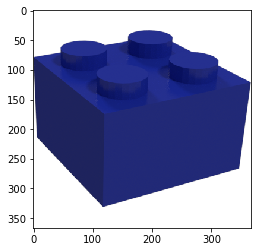

In [91]:
plt.imshow(a)

In [92]:
a.shape

(367, 367, 3)

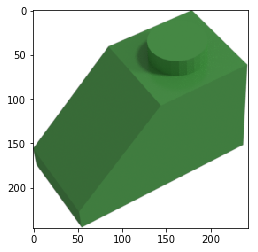

In [143]:
plt.imshow(a)

In [ ]:
#_X = [dat.images]

In [28]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(_X)

NameError: name '_X' is not defined

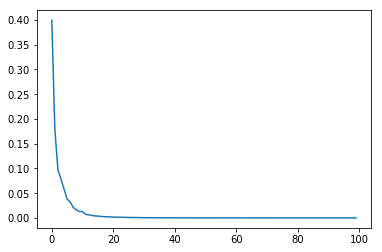

In [8]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

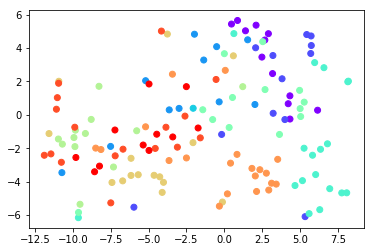

In [9]:
pca = KernelPCA(n_components=100)
X_pca = pca.fit_transform(_X)
X_embedded = TSNE(n_components=2).fit_transform(X_pca)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c = np.array(dat.colours_vector), cmap=plt.cm.rainbow)
plt.show()

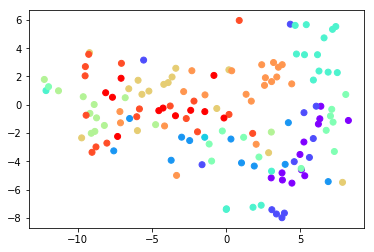

In [10]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(_X)
X_embedded = TSNE(n_components=2).fit_transform(X_pca)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = np.array(dat.colours_vector), cmap=plt.cm.rainbow)
plt.show()

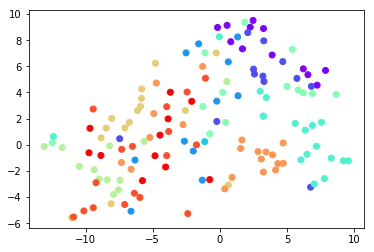

In [11]:
X_embedded = TSNE(n_components=2).fit_transform(_X)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = np.array(dat.colours_vector), cmap=plt.cm.rainbow)
plt.show()

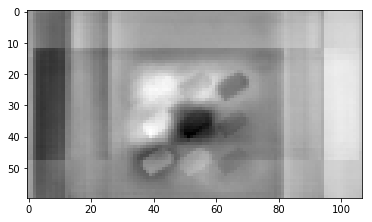

In [12]:
plt.imshow(np.load(dat.features_files[0])[:,:,1], cmap=plt.get_cmap('gray'))
plt.show()